# Bayesian Optimization

## O que é?

A otimização de bayes consiste em gerar uma função "substituta" para a função objetivo (seria a função ideal para descrever o modelo), utiliza os pontos mais próximos entre a função real e a substituta e gera uma nova zona ao redor desses pontos. Tenta otimizar os hiperparâmetros da função substituta de modo que aproxime cada ponto da zona de variação com o valor real da função. Ao invés de testar todo o conjunto de hiperparâmetros (grid search) ou pontos aleatórios em uma lista predefinida (random search) a otimização de Bayes testa os conjuntos de hp baseada nos resultados anteriores.

Por exemplo: 

Considere um algoritmo Random Forest e o hiperparâmetro n_estimators (nº de árvores), os métodos grid e random search percorreriam uma lista de possíveis conjuntos de hiperparâmetros independente do resultado de um ou outro conjunto, enquanto isso, a otimização bayesiana encontra uma região no espaço de configurações hiperparamétricas onde estão os melhores resultados, e aplica suas buscas apenas nessa região.

https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

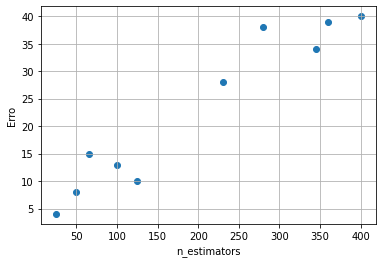

Nesse exemplo um número de estimadores bom seria inferior a 150, sendo assim a otimização bayesiana utiliza o conjunto de hiperparâmetros dos modelos localizados nessa região e busca novos conjuntos próximos aos encontrados


In [77]:
import numpy as np
import matplotlib.pyplot as plt

Xplot = np.array([25, 50, 65, 100, 125, 230, 280, 345, 360, 400])
Yplot = np.array([4, 8, 15, 13, 10, 28, 38, 34, 39, 40])

plt.figure()
plt.scatter(Xplot, Yplot)
plt.grid()
plt.ylabel("Erro")
plt.xlabel("n_estimators")
plt.show()

print("Nesse exemplo um número de estimadores bom seria inferior a 150, sendo assim a otimização bayesiana utiliza o conjunto de"
      " hiperparâmetros dos modelos localizados nessa região e busca novos conjuntos próximos aos encontrados")

### Exemplo

Para implementar a otimização bayesiana será utilizada a biblioteca skopt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import time

from skopt import BayesSearchCV

#### Coletando os dados

In [2]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4
4,142.529999,138.050003,137.949997,131.740005,135.679993
5,144.229996,142.529999,138.050003,137.949997,131.740005
6,144.199997,144.229996,142.529999,138.050003,137.949997
7,143.800003,144.199997,144.229996,142.529999,138.050003
8,145.389999,143.800003,144.199997,144.229996,142.529999


In [3]:
#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#### Criando modelos padrão

In [4]:
# configuração default para svr
# kernel = rbf, degree = 3, gamma = scale, coef0 = 0.0, tol = 1e-3, C=1.0,
# epsilon = 0.1, shrinking = True, cache_size = 200, verbose = False, max_iter = -1
svm_default = SVR()

# Random Forest
# n_estimators = 100, criterion = "mse", max_depth = None, min_samples_split = 2, max_features = "auto", 
# oob_score=false, max_samples=none
rf_default = RandomForestRegressor()

# XGBoost
# n_estimators, max_depth, learning_rate, booster, gamma, subsample, reg_alpha, reg_lambda
xgb_default = xgb.XGBRegressor()

#### Criando lista de hp

In [30]:
svm_space= {
    'kernel':['linear','rbf'],
    'gamma': ['scale','auto'],
    'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'epsilon':  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

rf_space = {'n_estimators':[30,50,100,150,300,500,750], 
            'criterion':['mse','mae'], 
            'min_samples_split':[2,3,5,7,10,15],
            'max_features':['auto','sqrt','log2'], 
            'oob_score':[True,False], 
            'max_samples':[0.3,0.5,0.75,0.8,0.9,0.99]}

xgb_space= {
    'n_estimators': [25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'booster':['gbtree','gblinear']
}

#### Ajustando modelos e obtendo resultados

In [31]:
#Buscando hyperparametros

svm_tune = BayesSearchCV(svm_default, svm_space, n_iter = 50, random_state = 10, cv = 5)

rf_tune = BayesSearchCV(rf_default, rf_space, n_iter = 50, random_state = 10, cv = 5)

xgb_tune = BayesSearchCV(xgb_default, xgb_space, n_iter = 50, random_state = 10, cv = 5)

In [32]:
ini = time.time()

svm_ini = time.time()
svm_tune.fit(X_train, y_train)
svm_fim = time.time()

print(svm_tune.best_params_)
print("Tempo (s): ", svm_fim-svm_ini)

rf_ini = time.time()
rf_tune.fit(X_train, y_train)
rf_fim = time.time()

print(rf_tune.best_params_)
print("Tempo (s): ", rf_fim-rf_ini)

xgb_ini = time.time()
xgb_tune.fit(X_train, y_train)
xgb_fim = time.time()

print(xgb_tune.best_params_)
print("Tempo (s): ", xgb_fim-xgb_ini)

fim = time.time()
print("Tempo total (s): ", fim-ini)

OrderedDict([('C', 0.1), ('epsilon', 0.8), ('gamma', 'auto'), ('kernel', 'linear')])
Tempo (s):  87.51078701019287
OrderedDict([('criterion', 'mse'), ('max_features', 'auto'), ('max_samples', 0.5), ('min_samples_split', 5), ('n_estimators', 750), ('oob_score', True)])
Tempo (s):  308.6647024154663
[16:39:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_by


[16:39:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p

[16:39:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[16:39:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[16:39:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[16:39:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[16:40:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[16:40:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[16:40:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa


[16:40:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p


[16:40:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p

In [43]:
svm_tuned = SVR(C=0.1, epsilon = 0.8, gamma = 'auto', kernel = 'linear')

rf_tuned = RandomForestRegressor(n_estimators = 750, min_samples_split = 5, max_features = 'auto', criterion = 'mse',
                                max_samples = 0.5, oob_score=True)

xgb_tuned = xgb.XGBRegressor(n_estimators = 450,learning_rate = 0.9, booster = 'gblinear')

In [44]:
#Modelos padrão
svm_default.fit(X_train,y_train)
rf_default.fit(X_train,y_train)
xgb_default.fit(X_train,y_train)

#Modelos ajustados
svm_tuned.fit(X_train,y_train)
rf_tuned.fit(X_train,y_train)
xgb_tuned.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.9, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=450, n_jobs=0, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

In [45]:
#Recolhendo pontuações

#Modelos padrão
svm_default_score = svm_default.score(X_test,y_test)
rf_default_score = rf_default.score(X_test,y_test)
xgb_default_score = xgb_default.score(X_test,y_test)

#Modelos ajustados
svm_tuned_score = svm_tuned.score(X_test,y_test)
rf_tuned_score = rf_tuned.score(X_test,y_test)
xgb_tuned_score = xgb_tuned.score(X_test,y_test)

In [46]:
#Recolhendo previsões

#Modelos padrão
svm_default_pred = svm_default.predict(X)
rf_default_pred = rf_default.predict(X)
xgb_default_pred = xgb_default.predict(X)

#Modelos ajustados
svm_tuned_pred = svm_tuned.predict(X)
rf_tuned_pred = rf_tuned.predict(X)
xgb_tuned_pred = xgb_tuned.predict(X)

In [47]:
print('--RELATÓRIO--')

print('SVM:')
print('Default score: ',svm_default_score)
print('Tuned score: ',svm_tuned_score)
print('--------------------')

print('Random Forest:')
print('Default score: ',rf_default_score)
print('Tuned score: ',rf_tuned_score)
print('--------------------')

print('XGBoost:')
print('Default score: ',xgb_default_score)
print('Tuned score: ',xgb_tuned_score)
print('--------------------')

--RELATÓRIO--
SVM:
Default score:  0.85605189803503
Tuned score:  0.9501425949103359
--------------------
Random Forest:
Default score:  0.9391873535308487
Tuned score:  0.9433420162144415
--------------------
XGBoost:
Default score:  0.9347909493592949
Tuned score:  0.9236233439214747
--------------------


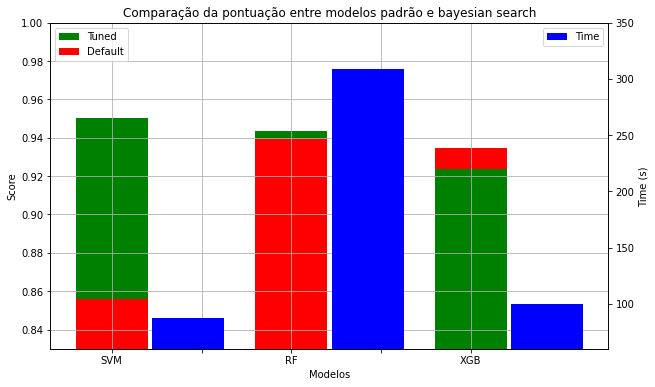

In [82]:
#Visualizando resultados

#plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(0, svm_tuned_score, color='green', label='Tuned')
ax1.bar(0, svm_default_score, color='red', label='Default')

ax1.bar(2, rf_tuned_score, color='green')
ax1.bar(2, rf_default_score, color='red')

ax1.bar(4, xgb_default_score, color='red')
ax1.bar(4, xgb_tuned_score, color='green')

ax1.set_ylim(0.83, 1.0)
ax1.set_ylabel('Score')
ax1.set_xlabel('Modelos')
ax1.set_title('Comparação da pontuação entre modelos padrão e bayesian search')
ax1.legend(loc='upper left')

ax1.grid()

# Plotando tempos
ax2 = ax1.twinx()

ax2.bar(0.85, svm_fim-svm_ini, color='blue', label='Time')
ax2.bar(2.85, rf_fim-rf_ini, color='blue')
ax2.bar(4.85, xgb_fim-xgb_ini, color='blue')
ax2.set_ylim(60, 350)
ax2.set_ylabel('Time (s)')
ax2.legend(loc='upper right')


plt.xticks(np.arange(5),['SVM','','RF','','XGB'])
plt.show()

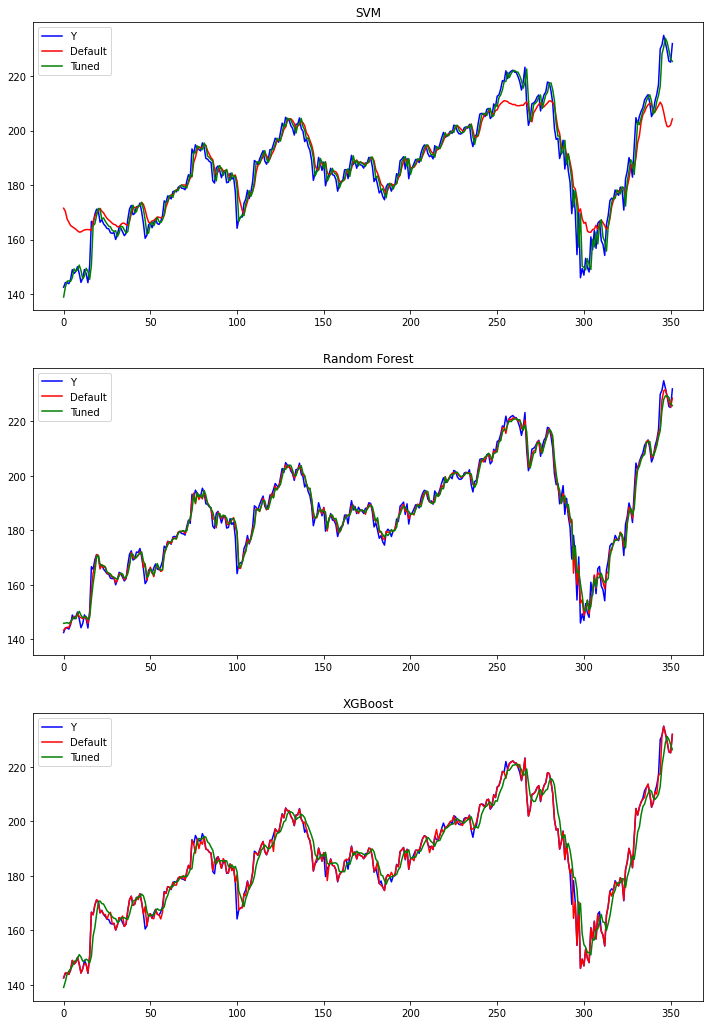

In [75]:
#plotando previsões

fig, ax = plt.subplots(nrows = 3, ncols = 1, sharey = True,  figsize=(12,18))

ax[0].plot(y, color='blue', label='Y')
ax[0].plot(svm_default_pred, color='red', label='Default')
ax[0].plot(svm_tuned_pred, color='green', label='Tuned')
ax[0].legend()
ax[0].set_title("SVM")

ax[1].plot(y, color='blue', label='Y')
ax[1].plot(rf_default_pred, color='red', label='Default')
ax[1].plot(rf_tuned_pred, color='green', label='Tuned')
ax[1].legend()
ax[1].set_title("Random Forest")

ax[2].plot(y, color='blue', label='Y')
ax[2].plot(xgb_default_pred, color='red', label='Default')
ax[2].plot(xgb_tuned_pred, color='green', label='Tuned')
ax[2].legend()
ax[2].set_title("XGBoost")

plt.show()

Utilizando a biblioteca HyperOpt

In [71]:
from sklearn.model_selection import cross_val_score
from hyperopt import hp, STATUS_OK, tpe, Trials, fmin

hp_trials = Trials()
tpe_algorithm = tpe.suggest
MAX_EVALS = 200

def objective_xgb_early(params):
    xgb_model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
    score = cross_val_score(xgb_model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}  

def objective_xgb(params):
    xgb_model = xgb.XGBRegressor(**params)
    score = cross_val_score(xgb_model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}  

def objective_rf(params):
    rf_model = RandomForestRegressor(**params)
    score = cross_val_score(rf_model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}  

def objective_svm(params):
    svr_model = SVR(**params)
    score = cross_val_score(svr_model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}  

In [72]:
svm_space= {
    'kernel':hp.choice('kernel', ['linear', 'rbf']),
    'gamma':hp.choice('gamma', ['scale', 'auto']),
    'C': hp.quniform('C', 0.1, 1, 0.1),
    'epsilon': hp.quniform('epsilon', 0.1, 1, 0.1),
}

rf_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(25, 600, dtype=int)), 
    'max_features':hp.choice('max_features', ['auto', 'sqrt']),
    'criterion':hp.choice('criterion', ['mse', 'mae']),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 20, dtype=int)), 
    'max_samples': hp.quniform('max_samples', 0.1, 0.9, 0.1),
}

xgb_space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'n_estimators': hp.choice('n_estimators', np.arange(25, 600, dtype=int)),
    'booster': hp.choice('booster', ['gbtree', 'gblinear']),
}

In [75]:
svm_ini = time.time()
svm_best = fmin(fn = objective_svm, space = svm_space, algo = tpe_algorithm, max_evals = MAX_EVALS, trials=Trials()) 
svm_fim = time.time()

rf_ini = time.time()
rf_best = fmin(fn = objective_rf, space = rf_space, algo = tpe_algorithm, max_evals = MAX_EVALS, trials=Trials())
rf_fim = time.time()

xgb_ini = time.time()
xgb_best = fmin(fn = objective_xgb, space = xgb_space, algo = tpe_algorithm, max_evals = MAX_EVALS, trials=Trials())
xgb_fim = time.time()

xgb_early_ini = time.time()
xgb_early_best = fmin(fn = objective_xgb_early, space = xgb_space, algo = tpe_algorithm, max_evals = MAX_EVALS, trials=Trials())
xgb_early_fim = time.time()

100%|█████████████████████████████████████████████| 200/200 [01:13<00:00,  2.71trial/s, best loss: -0.9545490184106248]
[15:31:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:20] WARNING: C:\Users\Administrator\wor

[15:31:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:31:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might no

[15:32:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


100%|█████████████████████████████████████████████| 200/200 [01:22<00:00,  2.41trial/s, best loss: -0.9550295978810249]


In [76]:
print(svm_best)
print(rf_best)
print(xgb_best)
print(xgb_early_best)

{'C': 1.0, 'epsilon': 0.8, 'gamma': 1, 'kernel': 0}
{'criterion': 0, 'max_features': 0, 'max_samples': 0.7000000000000001, 'min_samples_split': 6, 'n_estimators': 138}
{'booster': 1, 'learning_rate': 0.890491394891927, 'n_estimators': 432}
{'booster': 1, 'learning_rate': 0.7854877120954684, 'n_estimators': 319}


In [79]:
#Criando modelos ajustados

svm_tuned = SVR(C=1.0, epsilon=0.8, gamma = 'auto', kernel='linear')

rf_tuned = RandomForestRegressor(criterion='mse', max_features='auto',max_samples=0.7,min_samples_split=6, n_estimators=138)

xgb_tuned = xgb.XGBRegressor(booster = 'gblinear', learning_rate=0.89, n_estimators=432)

xgb_early_tuned = xgb.XGBRegressor(booster = 'gblinear', learning_rate=0.78, n_estimators=319)

In [80]:
#Treinando modelos
#Modelos padrão
svm_default.fit(X_train,y_train)
rf_default.fit(X_train,y_train)
xgb_default.fit(X_train,y_train)

#Modelos ajustados
svm_tuned.fit(X_train,y_train)
rf_tuned.fit(X_train,y_train)
xgb_tuned.fit(X_train,y_train)
xgb_early_tuned.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.78, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=319, n_jobs=0, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

In [81]:
#Recolhendo previsões

#Modelos padrão
svm_default_pred = svm_default.predict(X)
rf_default_pred = rf_default.predict(X)
xgb_default_pred = xgb_default.predict(X)

#Modelos ajustados
svm_tuned_pred = svm_tuned.predict(X)
rf_tuned_pred = rf_tuned.predict(X)
xgb_tuned_pred = xgb_tuned.predict(X)
xgb_early_tuned_pred = xgb_early_tuned.predict(X)

In [82]:
#Recolhendo pontuações

#Modelos padrão
svm_default_score = svm_default.score(X_test,y_test)
rf_default_score = rf_default.score(X_test,y_test)
xgb_default_score = xgb_default.score(X_test,y_test)

#Modelos ajustados
svm_tuned_score = svm_tuned.score(X_test,y_test)
rf_tuned_score = rf_tuned.score(X_test,y_test)
xgb_tuned_score = xgb_tuned.score(X_test,y_test)
xgb_early_tuned_score = xgb_early_tuned.score(X_test,y_test)

In [83]:
print('--RELATÓRIO--')

print('SVM:')
print('Default score: ',svm_default_score)
print('Tuned score: ',svm_tuned_score)
print('--------------------')

print('Random Forest:')
print('Default score: ',rf_default_score)
print('Tuned score: ',rf_tuned_score)
print('--------------------')

print('XGBoost:')
print('Default score: ',xgb_default_score)
print('Tuned score: ',xgb_tuned_score)
print('Tuned + Early Stopping score: ',xgb_early_tuned_score)
print('--------------------')

--RELATÓRIO--
SVM:
Default score:  0.85605189803503
Tuned score:  0.950172606889572
--------------------
Random Forest:
Default score:  0.9415540567298781
Tuned score:  0.9435479872545784
--------------------
XGBoost:
Default score:  0.9347909493592949
Tuned score:  0.9253219930842025
Tuned + Early Stopping score:  0.9253355608123786
--------------------


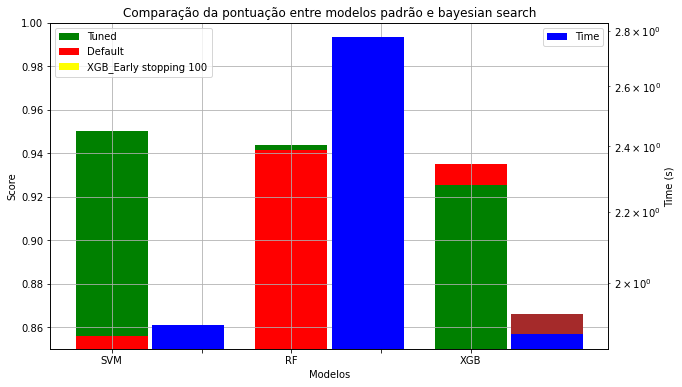

In [89]:
#Visualizando resultados
import math
#plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(0, svm_tuned_score, color='green', label='Tuned')
ax1.bar(0, svm_default_score, color='red', label='Default')

ax1.bar(2, rf_tuned_score, color='green')
ax1.bar(2, rf_default_score, color='red')

ax1.bar(4, xgb_default_score, color='red')
ax1.bar(4, xgb_early_tuned_score, color='yellow', label='XGB_Early stopping 100')
ax1.bar(4, xgb_tuned_score, color='green')

ax1.set_ylim(0.85, 1.0)
ax1.set_ylabel('Score')
ax1.set_xlabel('Modelos')
ax1.set_title('Comparação da pontuação entre modelos padrão e bayesian search')
ax1.legend(loc='upper left')

ax1.grid()

# Plotando tempos
ax2 = ax1.twinx()
ax2.bar(0.85, math.log(svm_fim-svm_ini,10), color='blue', label='Time')
ax2.bar(2.85, math.log(rf_fim-rf_ini,10), color='blue')
ax2.bar(4.85, math.log(xgb_early_fim-xgb_early_ini,10), color='brown')
ax2.bar(4.85, math.log(xgb_fim-xgb_ini,10), color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('Time (s)')
ax2.legend(loc='upper right')


plt.xticks(np.arange(5),['SVM','','RF','','XGB'])
plt.show()